 # **Predicting Player Engagement in Minecraft: A Data-Driven Look at Age and Gender**

## Introduction

**Background:**


The research group led by Frank Wood at the University of British Columbia (UBC) is conducting an interesting study about how people play video games, specifically focusing on player behavior within the Minecraft game environment. Minecraft is an open-world sandbox video game where players can explore, mine, build, and survive in a block-based virtual world. It has a wide, global player base, and players often interact with the world in different ways, depending on their playstyle. Some players engage in complex construction projects, while others may focus more on survival or exploration.

The research group is interested in understanding player behavior within this environment to answer practical questions about how to best allocate resources for their research project. The data they collect from the Minecraft server tracks players' actions as they navigate through the game world. This data is valuable for understanding how different factors, such as a player's age and gender, may influence their gaming habits, including how much data they contribute to the server.

The team aims to use this information for efficient planning. Specifically, they want to target their recruitment efforts toward certain kinds of players who are more likely to contribute a large amount of data. By understanding which kinds of players are more engaged, the team can ensure they have the necessary resources (like software licenses, server hardware, and recruitment strategies) to handle the expected number of players and the data they will generate.

**Question:**

The primary question the research group is trying to answer in this project is:
"Which kinds of players (based on factors like age and gender) are most likely to contribute a large amount of data in the Minecraft game environment?"

This question is critical because it will help the research team target recruitment efforts toward specific player demographics, ensuring they can manage server capacity and resource needs more effectively. The goal is to identify patterns in player engagement that correlate with age and gender and to leverage these insights in the recruitment process.


## Methods and Results

**Describe methods used to perfoem your analysis**

We will be using K-Nearest Neighbors (KNN) regression model, using cross-
validation to find the optimal number of neighbors.

We will start by Loading the data:

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
library(RColorBrewer)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [3]:
url <- "https://raw.githubusercontent.com/hy-008/dsci_project_1/refs/heads/main/data/players.csv"
player <- read_csv(url)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
player

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


**Wrangles and Cleaning the data**

We will select the columns played_hours, Age, and gender from the data, and ensure
that any NA values are filtered out. Additionally, we will be binarizing our data for kNN regression, representing female as 1 and male as 2

Upon reviewing, we found that out of 196 entries, 33 entries are labeled as neither
"Male" nor "Female". While it is important to acknowledge and respect all gender
identities, for the purpose of our analysis, we will focus on the "Male" and "Female"
categories as it makes up a much bigger sample size. Including all other gender
categories could lead to reduced model's performance during kNN regression.

In [5]:
player <- player |>
select(played_hours, Age, gender) |>
filter(gender == c("Male", "Female")) |>
mutate(gender = as.numeric(factor(gender)))

player

played_hours,Age,gender
<dbl>,<dbl>,<dbl>
30.3,9,2
0.0,17,2
0.7,21,1
⋮,⋮,⋮
0.0,17,1
0.3,22,2
2.3,17,2


We then set a seed and split the data to ensure a reproducible analysis. This step
guarantees that the training and testing sets are representative of the original data, which can be used to build our kNN regression model effectively.

In [6]:
set.seed(1)

player_split <- initial_split(player, prop = 0.7, strata = played_hours)
player_training <- training(player_split)
player_testing <- testing(player_split)

Warning message:
“The number of observations in each quantile is below the recommended threshold of 20.
• Stratification will use 3 breaks instead.”


**Summarize the dataset** We used the summary() function to provide comprehensive
overview of the data, including key statistics such as mean, median, minimum, and maximum values for each column.

In [7]:
summary_player <- summary(player)
cat("\nSummary Statistics:\n")
summary_player


Summary Statistics:


  played_hours          Age            gender     
 Min.   :  0.000   Min.   : 8.00   Min.   :1.000  
 1st Qu.:  0.000   1st Qu.:17.00   1st Qu.:2.000  
 Median :  0.100   Median :18.50   Median :2.000  
 Mean   :  5.400   Mean   :19.49   Mean   :1.795  
 3rd Qu.:  0.875   3rd Qu.:22.00   3rd Qu.:2.000  
 Max.   :223.100   Max.   :46.00   Max.   :2.000  

**Visualization of the Dataset**

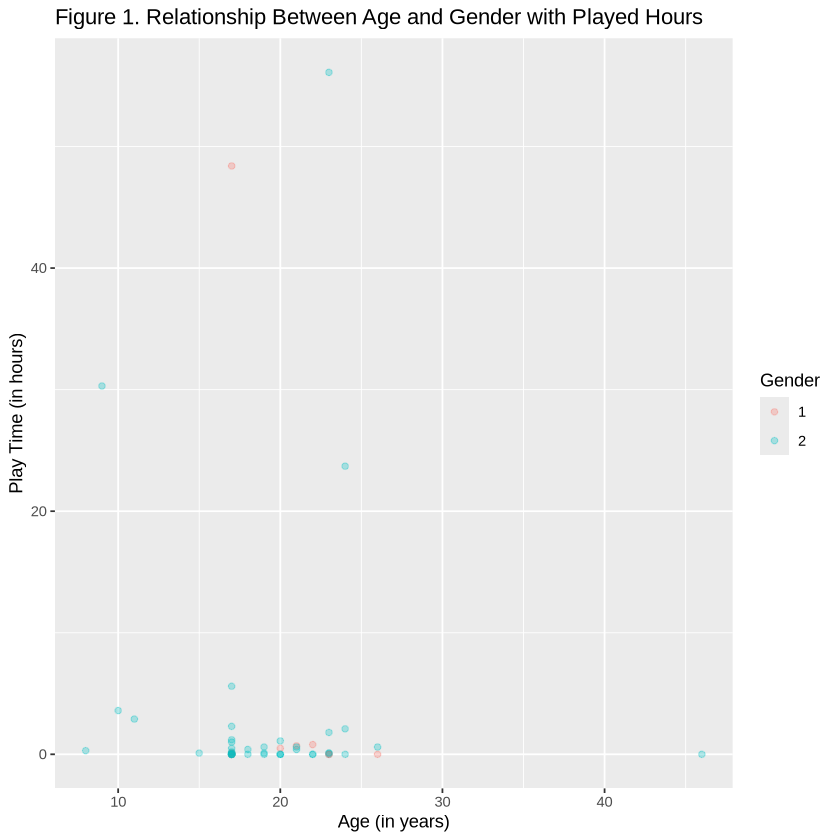

In [22]:
hours_chart <- player_training |>
                ggplot(aes(x = Age, y = played_hours, color = as.factor(gender))) +
                geom_point(alpha = 0.3) + #there is overplotting
                labs(x = "Age (in years)", 
                     y = "Play Time (in hours)", color = "Gender") +
                ggtitle("Figure 1. Relationship Between Age and Gender with Played Hours") 
hours_chart

**Performing the Data Analysis**

The process includes creating a recipe, where all predictors' values are normalized
(scale and center), which is important as it ensures that all features contribute
equally to the model. Then, we plan to use a 5-fold cross-validation for our data,
which will be used to tune the model. Finally, we want to find the best number for k
value. This is done by slicing the row with the lowest value of RMSE.

In [9]:
player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("regression") 

player_recipe <- recipe(played_hours ~ Age + gender, data = player_training) |>
      step_scale(all_predictors()) |>
      step_center(all_predictors())

player_vfold <- vfold_cv(player_training, v = 5, strata = played_hours)

player_wf <- workflow() |>
                add_recipe(player_recipe) |>
                add_model(player_spec)

gridvals <- tibble(neighbors = seq(from = 1, to = 25, by = 1))

player_results <- player_wf |>
                    tune_grid(resample = player_vfold, grid = gridvals) |>
                    collect_metrics()

player_min <- player_results |>
                filter(.metric == "rmse") |>
                slice_min(order_by = mean, n = 1)

player_results
player_min

Warning message:
“The number of observations in each quantile is below the recommended threshold of 20.
• Stratification will use 2 breaks instead.”


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,11.97470834,5,3.246868992,Preprocessor1_Model01
1,rsq,standard,0.01665388,5,0.004575902,Preprocessor1_Model01
2,rmse,standard,11.69904419,5,2.795907177,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
24,rsq,standard,0.04569143,5,0.02671007,Preprocessor1_Model24
25,rmse,standard,9.62567434,5,3.04354074,Preprocessor1_Model25
25,rsq,standard,0.15684071,5,0.09352489,Preprocessor1_Model25


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
24,rmse,standard,9.603852,5,3.028109,Preprocessor1_Model24


In [10]:
k_min <- player_min |>
        pull(neighbors)

player_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
         set_engine("kknn") |>
         set_mode("regression")

player_best_fit <- workflow() |>
         add_recipe(player_recipe) |>
         add_model(player_best_spec) |>
         fit(data = player_training)

player_summary <- player_best_fit |>
          predict(player_testing) |>
          bind_cols(player_testing) |>
          metrics(truth = played_hours, estimate = .pred)

player_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,45.5051697
rsq,standard,0.0601851
mae,standard,11.4876736


**Visualization of the Analysis**

Despite removing any missing values, the minimum RMSE value is still high (45.5).
This is caused by the presence of outliers in played hours, as seen in the summary
table. To better understand the relationship, this is the visualization of the
relationship between age and gender with played_hours

In [15]:
player_preds

.pred,played_hours,Age,gender
<dbl>,<dbl>,<dbl>,<dbl>
0.5541667,0.0,17,2
2.4166667,0.0,17,1
0.5541667,0.1,17,2
⋮,⋮,⋮,⋮
3.6583333,2.1,24,2
5.6000000,0.8,22,1
0.5541667,2.3,17,2


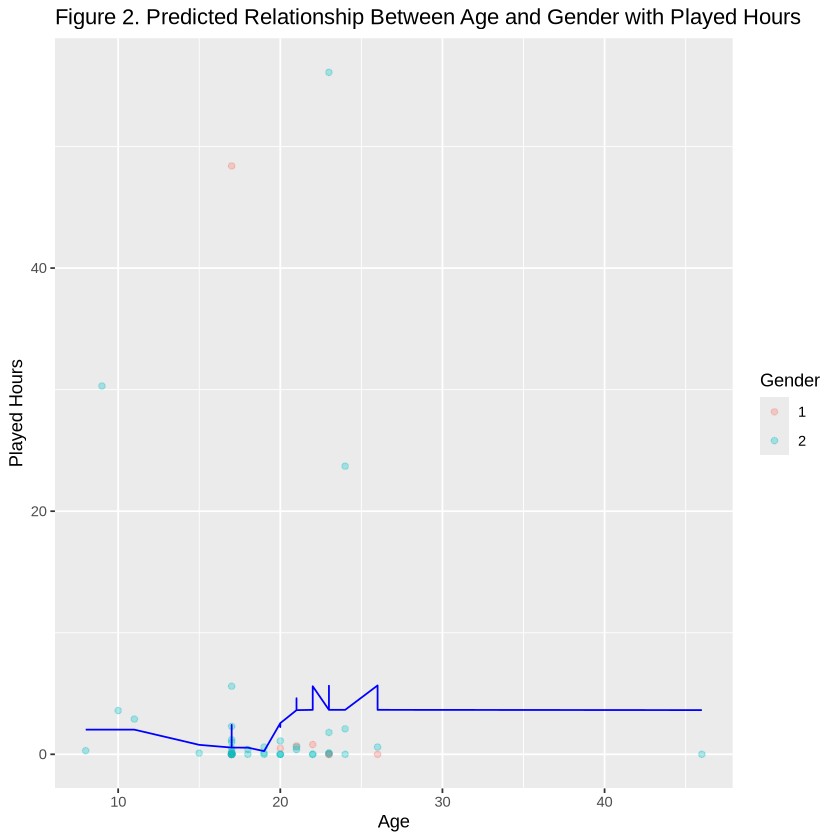

In [23]:
options(repr.plot.width = 7, repr.plot.height = 7)

player_preds <- player_best_fit |>
predict(new_data = player_training) |>
bind_cols(player_training)

player_plot <- ggplot(player_preds, aes(x = Age, y = played_hours, color = as.factor(gender))) +
geom_point(alpha = 0.3) +
geom_line(aes(x = Age, y = .pred, color = gender), color = "blue") +
labs(
    title = "Figure 2. Predicted Relationship Between Age and Gender with Played Hours ",
    x = "Age",
    y = "Played Hours", 
    color = "Gender"
)

player_plot

In [19]:
new_player <- tibble(Age = c(10, 20, 20, 10), gender = c(1, 2, 1, 2))
prediction <- predict(player_best_fit, new_player)

prediction

sec_player <- tibble(Age = c(40, 30, 30, 40), gender = c(1, 2, 1, 2))
sec_prediction <- predict(player_best_fit, sec_player)

sec_prediction

.pred
<dbl>
3.975000
2.566667
2.241667
2.029167


.pred
<dbl>
5.666667
3.658333
5.666667
3.637500


## Discussion

**Summarize what you found**

We found that age and gender, while being basic demographic factors, don’t strongly predict how much someone plays Minecraft. Using a K-Nearest Neighbors (KNN) regression model, we tried to estimate each player’s total playtime based on these two variables. Even after cleaning the data and tuning the model, the prediction error (RMSE) remained high—around 45 hours, which suggests the model wasn't very accurate.

When we visualized the data, we didn’t see any clear trends or groupings either. Older players didn’t necessarily play less, and there wasn’t a big difference between male and female players in terms of hours played. Overall, the data showed a wide range of behaviors, and there were quite a few outliers. This suggests that age and gender alone aren’t enough to explain how engaged a player is.


**Discuss whether this is what you expected to find?**

Honestly, we expected age and gender to have at least some influence on how much people played, even if just loosely. It seemed reasonable to assume, for example, that younger players might have more free time to spend in-game or that there might be noticeable engagement differences between genders. But what we found was that those two factors didn’t really help predict playtime at all. The model struggled to make accurate predictions, and the data didn’t show any strong patterns.

That was a bit surprising at first, but it also kind of makes sense the more we think about it. Gaming habits are shaped by so many things beyond age and gender, like school or work schedules, personal interests, motivation, or even the specific way someone likes to play. Two people of the same age and gender might have completely different playstyles or levels of commitment. So, in the end, while we hoped for clearer trends, it makes sense that human behavior, especially in an open-ended game like Minecraft, isn’t that easy to box into simple categories.

**Discuss what impact could such findings have?**

Even though the model didn’t find strong predictive power in age or gender, that actually tells us something useful. It means that relying on simple demographic categories might not be the best strategy for recruiting players who will contribute a lot of data. If the research team at UBC wants to focus its resources efficiently, it may need to consider other variables, like in-game behavior patterns, session frequency, or how players interact with certain features, rather than just who the players are on paper.

This could also shift the way similar studies approach recruitment and data planning. Instead of making assumptions based on age or gender, it encourages a more behavior-based strategy that looks at what players do, not just who they are. It’s a reminder that player engagement is complex and personal, and understanding that complexity can lead to better research design and smarter use of server capacity, incentives, and resources.

**Discuss what future questions could this lead to?**

This brings up a lot of follow-up questions, especially around what actually drives player engagement. If age and gender don’t tell us much, then what might be worth exploring in behavioral factors?

It also raises questions about how we define and measure “valuable” player contributions. Is it purely about hours played, or are there other types of engagement that matter just as much, like diversity of actions, creativity, or collaboration?

On a broader level, this could lead to asking how researchers can better capture and quantify qualitative behaviors in open-world environments. Maybe even looking into how motivation, personality, or game design itself influences how people play. There's definitely more to dig into beyond just the basics of age and gender.

